# VERIFICATION: DYNAMIC TESTING


# Preliminaries

## Imports

In [1]:
# Python packages used in this section
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request # use this library to download file from GitHub
from scipy import fftpack
try:
    from SBMLLint.tools.sbmllint import lint
except:
    !pip install -q SBMLLint
    from SBMLLint.tools.sbmllint import lint

## Helper Functions

In [2]:
def getSharedCodes(moduleName):
  """
  Obtains common codes from the github repository.

  Parameters
  ----------
  moduleName: str
      name of the python module in the src directory
  """
  url = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/src/%s.py" % moduleName
  local_python = "python.py"
  _, _ = urllib.request.urlretrieve(url=url, filename=local_python)
  with open(local_python, "r") as fd:
    codeStr = "".join(fd.readlines())
  print(codeStr)
  exec(codeStr, globals())
  os.remove(local_python)

# Acquire codes
getSharedCodes("util")

# TESTS
assert(isinstance(LINEAR_PATHWAY_DF, pd.DataFrame))

import pandas as pd
import urllib.request

# Linear pathway data
BASE_URL = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/"
BASE_DATA_URL = "%sdata/" % BASE_URL
BASE_MODULE_URL = "%ssrc/" % BASE_URL
BASE_MODEL_URL = "%smodels/" % BASE_URL
LOCAL_FILE = "local_file.txt"


def getData(csvFilename):
    """
    Creates a dataframe from a CSV structured URL file.

    Parameters
    ----------
    csvFilename: str
        Name of the CSV file (w/o ".csv" extension)

    Returns
    -------
    pd.DataFrame
    """
    url = "%s%s.csv" % (BASE_DATA_URL, csvFilename)
    filename, _ = urllib.request.urlretrieve(url, filename=LOCAL_FILE)
    return pd.read_csv(LOCAL_FILE)

def getModule(moduleName):
    """
    Obtains common codes from the github repository.
  
    Parameters
    ----------
    moduleName: str
        name of the python module in the src directory
    """
    url = "%s%s.py" % (BASE_MODULE_URL, moduleName)
    _, _ = urllib.request.urlretrieve(url, 

## Constants

In [3]:
# Constants
ENDTIME = 10
NUMPOINTS = 100

# Motivating Example

Dynamic testing is about verifying the output produced by a simulation.

This is illustrated at the beginning of the chapter using the example
of a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``, with ``S1`` initialized to 10. 

We showed that the following outcomes were expected from the simulation:

- **O1**: ``S1`` decreases monotonically from 10 to 0.
- **O2**: ``S2`` increases initially, peaks, and then declines to 0.
- **O3**: ``S3`` increases monotonically to 10. 


Let's consider an initial implementation that contains an error due to a typo in the kinetics law.

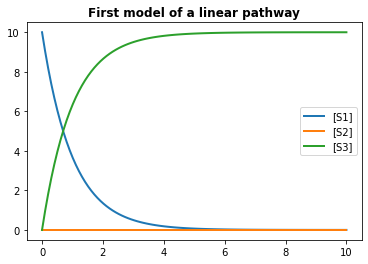

In [4]:
INCORRECT_MODEL = '''
R1: S1 -> S2; k1*S1  
R2: S2 -> S3; k2*S1

S1 = 10
k1 = 1; k2 = 1
'''
rr = te.loada(INCORRECT_MODEL)
data = rr.simulate(0, ENDTIME, NUMPOINTS)
rr.plot(data, title="First model of a linear pathway")

We see that ``S1`` and ``S3`` generally follow the expected pattern. But ``S2`` does not.
This is because of the error in the kinetics expression.
We correct this below.

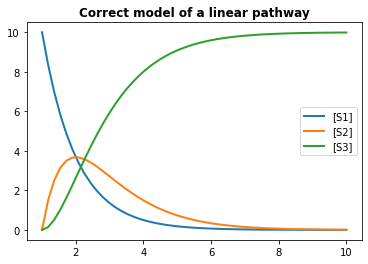

In [5]:
CORRECT_MODEL = '''
R1:  S1 -> S2; k1*S1  
R2a: S2 -> S3; k2*S2

S1 = 10
k1 = 1; k2 = 1;
'''
rr = te.loada(CORRECT_MODEL)
data = rr.simulate(1, 10)
rr.plot(data, title="Correct model of a linear pathway")

# Testing Expected Outcomes

The expected outcomes are the starting point for constructing verification tests.
Implementing these tests requires two Boolean helper functions.
A Boolean function returns either ``True`` or ``False``.
The first helper function, ``isMonotone``, takes as input a list or array of values and
the direction expected (+1 for monotone increasing and -1 for monotone decreasing).
The function returns ``True`` if the data are monotone in the desired direction.

In [6]:
def isMonotone(values, direction=1):
    """
    Check if series is monotone in the desired direction.

    Parameters
    ----------
    values: np.array or list
    direction: int
        1 (increasing), -1 (decreasing)

    Returns
    -------
    bool
    """
    arr = np.array(values)
    diff = direction*(arr[1:] - arr[:-1])
    return all([v > 0 for v in diff])

# TESTS
assert(isMonotone([0, 1, 2, 3], direction=1))
assert(not isMonotone([0, 1, 2, 1, 0]))
assert(isMonotone([4, 3, 2, 1], direction=-1))

``isMonotone`` allows us to check the conditions O1 and O3. For O2, we need to check that the values initially increase,
and then decrease. Curves with this shape are called *concave*. That is, there is some intermediate point at which the series changes from increasing to
decreasing. 

In [7]:
def isConcave(values, direction=1):
    """
    Check if series is monotone in the desired direction.
    Requires at least 4 values.

    Parameters
    ----------
    values: list-float
    direction: int
        1 (increasing), -1 (decreasing)

    Returns
    -------
    bool
    """
    if len(values) < 4:
        raise ValueError("Too few values to assess.")
    arr = np.array(values)
    result = False
    # Ensure have at least 2 values to check monotonicity in each direction
    for idx in range(2, len(values)-1):
        isIncreasing = isMonotone(arr[:idx], direction=1)
        isDecreasing = isMonotone(arr[idx:], direction=-1)
        if isIncreasing and isDecreasing:
            result = True
            break
    return result

# TESTS
assert(not isConcave([0, 1, 2, 3], direction=1))
assert(not isConcave([4, 3, 2, 1], direction=-1))
assert(isConcave([0, 1, 2, 1, 0]))

We illustrate these functions below.

In [8]:
# Illustration of isMonotone, isConcave
for values in [ [1, 2, 3, 4], [4, 3, 2, 1], [1, 4, 3, 2]]:
    print("\nAnalyzing the series: %s" % str(values))
    print("  Increasing? %s" % str(isMonotone(values, direction=1)))
    print("  Decreasing? %s" % str(isMonotone(values, direction=-1)))
    print("  Concave? %s" % str(isConcave(values)))


Analyzing the series: [1, 2, 3, 4]
  Increasing? True
  Decreasing? False
  Concave? False

Analyzing the series: [4, 3, 2, 1]
  Increasing? False
  Decreasing? True
  Concave? False

Analyzing the series: [1, 4, 3, 2]
  Increasing? False
  Decreasing? False
  Concave? True


# Test Infrastructure

Now that we have a way to test the outcomes, we need to write codes that use these tests.
Fortunately, python provides a convenient way to do this with its ``unittest`` infrastructure.
Using the infrastructure requires the following:
- Copy the test template. The template consists of:
  - ``import unittest``
  - ``class TestModel(unittest.TestCase)``
- Write a setUp function within ``TestModel`` that loads the model and gets simulation data.
- Write tests that check the appropriate values in the simulation output.

This is done below for the linear pathway.
Note that the code expects that the variable ``MODEL`` is the antimony codes for the model being tested. We see that there
is a separate test for each column.

In [9]:
import unittest

# Performs unittests on MODEL


class TestModel(unittest.TestCase):
    
    def setUp(self):
        self.roadrunner = te.loada(CORRECT_MODEL)
        self.data = self.roadrunner.simulate(0, 10, 100)
        
    def testS1(self):
        self.assertTrue(isMonotone(self.data["[S1]"], direction=-1))
        
    def testS2(self):
        self.assertTrue(isConcave(self.data["[S2]"]))
                
    def testS3(self):
        self.assertTrue(isMonotone(self.data["[S3]"], direction=1))

suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.017s

OK


In [10]:
import unittest

# Performs unittests on MODEL

def testModel(model):
    """
    Runs tests to evaluate a model.

    Parameters
    ----------
    model: str
        antimony model
    """
    class TestModel(unittest.TestCase):
        
        def setUp(self):
            self.roadrunner = te.loada(model)
            self.data = self.roadrunner.simulate(0, 10, 100)
            
        def testS1(self):
            self.assertTrue(isMonotone(self.data["[S1]"], direction=-1))
            
        def testS2(self):
            self.assertTrue(isConcave(self.data["[S2]"]))
                    
        def testS3(self):
            self.assertTrue(isMonotone(self.data["[S3]"], direction=1))
    suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
    _ = unittest.TextTestRunner().run(suite)

To run the model, you assign ``MODEL`` and then run the two lines that follow this assignment.

In [11]:
testModel(CORRECT_MODEL)

...
----------------------------------------------------------------------
Ran 3 tests in 0.017s

OK


These codes ran the 3 tests. All three passed for ``CORRECT_MODEL``. Now consider what happens with the model in ``INCORRECT_MODEL`` that fails on the test for ``S2``.

In [12]:
testModel(INCORRECT_MODEL)

.F.
FAIL: testS2 (__main__.testModel.<locals>.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-10-ec198792d72b>", line 24, in testS2
    self.assertTrue(isConcave(self.data["[S2]"]))
AssertionError: False is not true

----------------------------------------------------------------------
Ran 3 tests in 0.089s

FAILED (failures=1)


We have demonstrated these tests in the Jupyter notebook. However, in practice, the tests would be in
a separate python modeule (a file ending in ``.py``). Ideally, these test files are run whenever there is a
change to the model or its supporting code.
Systems such as ``github`` provide a way to run these tests automatically whenever the model changes, a process referred to
as *continuous integration*.

# Exercise

In [13]:
print(WOLF_MODEL)

// Created by libAntimony v2.12.0.3
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceralde

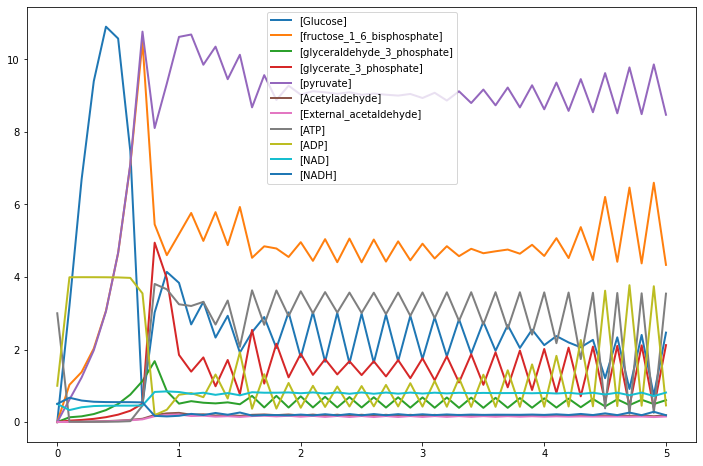

In [14]:
rr = te.loada(WOLF_MODEL)
rr.simulate()
rr.plot(figsize=(12,8))

This exercise uses the Wolf model of glycolytic oscillations.

1. What is the relationship between the concentrations of
glucose, furctose_1_6_bisphosphate, and pyruvate after the initial transients.
Does this relationship always hold?

1. Propose a test that checks for that the order of the concentrations at steady state of glucose, furctose_1_6_bisphosphate, and pyruvate.
Hint: Implement a function that checks that one vector
is greater than a second vector after a specified index.

1. Another characteristic of the Wolf model is the presence of oscillations at the same frequency.
Describe in words how you would implement a test to
checks for the presence of these oscillations.